### Module & Goggle Drive import

In [11]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  !pip install keras_tuner
except:
  pass

In [12]:
import os
import sys
import keras_tuner as kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.sequence import (
    pad_sequences    
)

from pprint import pprint
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler



## Constant definision

In [13]:
# If runs on google colab or not
try:
  import google.colab
  BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/drone_research"
except:
  BASE_DIR = "/home/israzex/Desktop/drone_homecoming_rl/artificial_gps"

DATA_FOLDER_NAME = "new_data"
DATA_FOLDER_PATH = os.path.join(BASE_DIR, DATA_FOLDER_NAME)


OUTPUT_DATA_COLUMNS = ["position_x", "position_y", "position_z"]
TIMESTAMP_COLUMNS = [
    "motor_state_timestamp",
    "barometer_timestamp",
    "magnetometer_timestamp",
    "rotor_timestamp"
]


INPUT_SEQUENCE_COLUMNS = ["angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z",
                          "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",
                          "angular_velocity_x", "angular_velocity_y", "angular_velocity_z",
                          "orientation_x", "orientation_y", "orientation_z", "orientation_w", "motor_state_timestamp",
                          "barometer_altitude", "barometer_pressure", 
                          # "barometer_qnh", Same value
                          "barometer_timestamp",
                          "magnetometer_magnetic_field_body_x", "magnetometer_magnetic_field_body_y",
                          "magnetometer_magnetic_field_body_x", "magnetometer_timestamp",
                          "rotor_a_speed", "rotor_a_thrust", "rotor_a_torque_scaler",
                          "rotor_b_speed", "rotor_b_thrust", "rotor_b_torque_scaler",
                          "rotor_c_speed", "rotor_c_thrust", "rotor_c_torque_scaler",
                          "rotor_d_speed", "rotor_d_thrust", "rotor_d_torque_scaler",
                          "rotor_timestamp"
                         ]
OUTPUT_SEQUENCE_COLUMNS = ["position_x", "position_y", "position_z"]
MAIN_TIMESTAMP_COLUMN = "motor_state_timestamp"
INPUT_SEQUENCE_LENGTH = 10


In [14]:
def get_recordings_files():
    all_csv_files = os.listdir(DATA_FOLDER_PATH)

    # Orders the "manual" files to the end (They are more likely represent 
    # the test user). So this data should be used as test
    auto_genereted_flights = [recording_file for recording_file in all_csv_files 
                              if not recording_file.startswith("manual")]
    manual_generated_flights = [recording_file for recording_file in all_csv_files 
                              if recording_file.startswith("manual")]

    all_csv_files = []
    all_csv_files.extend(auto_genereted_flights)
    all_csv_files.extend(manual_generated_flights)

    return all_csv_files


## Data Preprocessing

### Load data from single file

In [15]:
# Loads data from recording file
# Converts timestamp -> time offset from last timestamp
#          location  -> step made from last location in x time offset

def _convert_timestamp_to_interval_seconds(flight_input_df: pd.DataFrame, timestamp_columns: list):
    """
    Converts the timestamp fields into the amount of seconds between each two timestamps

    Note: each timestamp represents the amount eof NANO seconds (1,000,000,000 nanoseconds = 1 seconds)
    """
    # Converts the start time to time interval
    next_time_df = flight_input_df[timestamp_columns].shift(-1)
    time_diff_df = (next_time_df - flight_input_df[timestamp_columns]) / 1_000_000_000
    flight_input_df.loc[:, timestamp_columns] = time_diff_df
    return flight_input_df


def _convert_location_to_step(flight_output_df: pd.DataFrame):
    next_coordinates_df = flight_output_df.shift(-1)
    coordinate_diff = flight_output_df - next_coordinates_df

    return coordinate_diff


def load_flight_steps_from_file(csv_name: str, input_columns: list, output_columns: list):
    """

    @param csv_name:
    @param input_columns:
    @param output_columns:
    @return:
    """
    if not csv_name.endswith("csv"):
        raise ValueError(f"File with unsupported extension, expected csv (file: {csv_name})")

    csv_path = os.path.join(DATA_FOLDER_PATH, csv_name)
    flight_df = pd.read_csv(csv_path)
    flight_df = flight_df[::2] # every 20 ms

    x_df = flight_df[input_columns].copy()
    timestamp_columns = [column for column in input_columns if column in TIMESTAMP_COLUMNS]
    x_df = _convert_timestamp_to_interval_seconds(x_df, timestamp_columns)

    y_df = flight_df[output_columns].copy()
    y_df = _convert_location_to_step(y_df)

    # Drops the last record because the process is based of difference
    x_df.drop(x_df.tail(1).index, inplace=True)
    y_df.drop(y_df.tail(1).index, inplace=True)

    return x_df, y_df

### Preprocess Dataset


In [16]:
def load_dataset_sequences(input_columns: list, output_columns: list):
    """
    Loads flight steps and orders it to sequences of sequence_length length.
    In order to feed it to rnn/lstm s2s model

    @param input_columns: The input columns
    @param output_columns: The outputs columns
    @return:
    """
    all_csv_files = get_recordings_files()

    # x, y data from all flight sessions
    x_sessions = []
    y_sessions = []

    for csv_name in all_csv_files:
        try:
            x_df, y_df = load_flight_steps_from_file(csv_name, input_columns, output_columns)

            x_sessions.append(x_df.to_numpy())
            y_sessions.append(y_df.to_numpy())

        except ValueError as error:
            print(str(error))

   
    # Chooses the sequence size to train on
    sequence_size = int(np.mean(np.array([len(recording) for recording in x_sessions])))
    print(f"Padds input data to {sequence_size} length")

    padded_x_sessions = pad_sequences(x_sessions, maxlen=sequence_size, 
                                      truncating="post", padding="pre",
                                      dtype='float64')
    padded_y_sessions = pad_sequences(y_sessions, maxlen=sequence_size, 
                                      truncating="post", padding="pre",
                                      dtype='float64')
    
    x_data = np.stack(padded_x_sessions)
    y_data = np.stack(padded_y_sessions)

    # y_data = np.add.accumulate(y_data, axis=1)
    return x_data, y_data

In [17]:
def preprocess_dataset(x_data, y_data):
    # creating normalizers
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    x_data = scaler_x.fit_transform(x_data.reshape(-1, x_data.shape[-1])).reshape(x_data.shape)
    y_data = scaler_y.fit_transform(y_data.reshape(-1, y_data.shape[-1])).reshape(y_data.shape)

    return x_data, y_data, scaler_x, scaler_y

In [18]:
def load_preprocessed_sequence_dataset(input_columns: list, output_columns: list):
    """
    Loads the whole dataset with preprocessing

    @param input_columns: Input columns names
    @param output_columns: Output columns names
    @param sequence_length: The size of input x sequence
    @return: Loaded, preprocessed, shuffled, splitted data set
    """
    x_data, y_data = load_dataset_sequences(input_columns, output_columns)
    x_data, y_data, scaler_x, scaler_y = preprocess_dataset(x_data, y_data)

    train_x, dev_x, test_x = split_data(x_data)
    train_y, dev_y, test_y = split_data(y_data)
    
    train_x, train_y = shuffle_data_set(train_x, train_y)
    dev_x, dev_y = shuffle_data_set(dev_x, dev_y)

    return train_x, train_y, dev_x, dev_y, scaler_x, scaler_y

## Data visualization utils


In [ ]:
def print_plot_of_all_columns(flight_data: List[pd.DataFrame],
                              graphs_in_row=4,
                              row_height=5,
                              col_width=30,
                              graph_type="plot"):
  n_rowes = math.ceil(len(stock_names) / graphs_in_row) 
  fig, axes = plt.subplots(n_rowes, graphs_in_row)

  for row in range(n_rowes):
    for col in range(graphs_in_row):
      stock_index = row * graphs_in_row + col
      if stock_index < len(stock_names):
        stock_name = stock_names[stock_index]
        stock_df = stocks[stock_name]
        axes[row, col].plot(stock_df["open"])
        axes[row, col].set_title(stock_name)

  
  fig.set_size_inches(col_width, row_height * n_rowes)
  fig.suptitle(f"Cluster: {cluster_name}")
  plt.show()

def print_hist_of_all_columns(flight_data: List[pd.DataFrame],
                              graphs_in_row=4,
                              row_height=5,
                              col_width=30,
                              graph_type="plot"):
  n_rowes = math.ceil(len(stock_names) / graphs_in_row) 
  fig, axes = plt.subplots(n_rowes, graphs_in_row)

  for row in range(n_rowes):
    for col in range(graphs_in_row):
      stock_index = row * graphs_in_row + col
      if stock_index < len(stock_names):
        stock_name = stock_names[stock_index]
        stock_df = stocks[stock_name]
        if graph_type == "plot":
          axes[row, col].plot(stock_df["open"])
          axes[row, col].set_title(stock_name)

        if graph_type == "hist":
          axes[row, col].hist(stock_df["open"], bins=100)
          mean = np.mean(stock_df["open"])
          median = np.median(stock_df["open"])
          axes[row, col].set_title(f"{stock_name} (mean:{mean:.2f}/median:{median:.2f})")
  
  fig.set_size_inches(col_width, row_height * n_rowes)
  fig.suptitle(f"Cluster: {cluster_name}")
  plt.show()

In [62]:
def plot_corrolation_heatmap(df: pd.DataFrame, *args, **kwargs):
  corr_mat_hep = df.corr().round(2)
  plt.figure(figsize=(20,20))
  plot = sns.heatmap(corr_mat_hep, *args, **kwargs)
  plt.show()

## Feature Analysis

In [40]:
record_file_name = "manual_31Jan_00:35_record.csv"                    # Old interface with acceleation
record_file_name = "bot-simplified-2_09Apr_17:01_record.csv"          # New interface without acceleration. Uniform
record_file_path = os.path.join(DATA_FOLDER_PATH, record_file_name)

### Original Data

#### Initial feature analysis

In [ ]:
print(x_df.head())
print(y_df.head())

   angular_acceleration_x  angular_acceleration_y  angular_acceleration_z  \
0               -0.000683            6.303035e-11            1.168092e-08   
2                0.107627            4.561853e+01           -1.182129e-03   
4               -0.049068           -3.020247e+01           -9.488421e-05   
6               -0.041926            2.757795e+00           -2.039481e-04   
8               -0.008639           -1.080995e+01            3.587303e-05   

   linear_acceleration_x  linear_acceleration_y  linear_acceleration_z  \
0              -0.007450              -0.003786               0.002775   
2              -0.132108              -0.039736               1.278887   
4              -0.722980              -0.212926              -0.931341   
6              -1.043554              -0.306657              -1.434928   
8              -1.333480              -0.391462              -1.562953   

   angular_velocity_x  angular_velocity_y  angular_velocity_z  orientation_x  \
0           

In [ ]:
print(x_df.describe())
print()
print(y_df.describe())

       angular_acceleration_x  angular_acceleration_y  angular_acceleration_z  \
count            1.256000e+03             1256.000000            1.256000e+03   
mean            -1.160262e-03               -0.002011            3.322813e-07   
std              5.691572e-02                4.943097            2.113384e-04   
min             -6.680210e-01             -136.632660           -1.182129e-03   
25%             -9.754532e-05               -0.002205           -2.636949e-07   
50%             -1.055695e-15                0.000030           -4.611167e-13   
75%              4.877479e-05                0.012878            2.606636e-07   
max              8.840837e-01               50.713486            3.379712e-03   

       linear_acceleration_x  linear_acceleration_y  linear_acceleration_z  \
count            1256.000000            1256.000000            1256.000000   
mean                0.001904               0.004172              -0.001558   
std                 0.712518        

In [74]:
print(df.dtypes)

Unnamed: 0                              int64
gps_altitude                          float64
gps_latitude                          float64
gps_longitude                         float64
position_x                            float64
position_y                            float64
position_z                            float64
angular_acceleration_x                float64
angular_acceleration_y                float64
angular_acceleration_z                float64
angular_velocity_x                    float64
angular_velocity_y                    float64
angular_velocity_z                    float64
linear_acceleration_x                 float64
linear_acceleration_y                 float64
linear_acceleration_z                 float64
linear_velocity_x                     float64
linear_velocity_y                     float64
linear_velocity_z                     float64
orientation_x                         float64
orientation_y                         float64
orientation_z                     

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(x_df.corr(),annot=True);

#### Load Data

In [43]:
df = pd.read_csv(record_file_path)

#### Visualization

##### All Data

###### Plot

All Columns plot


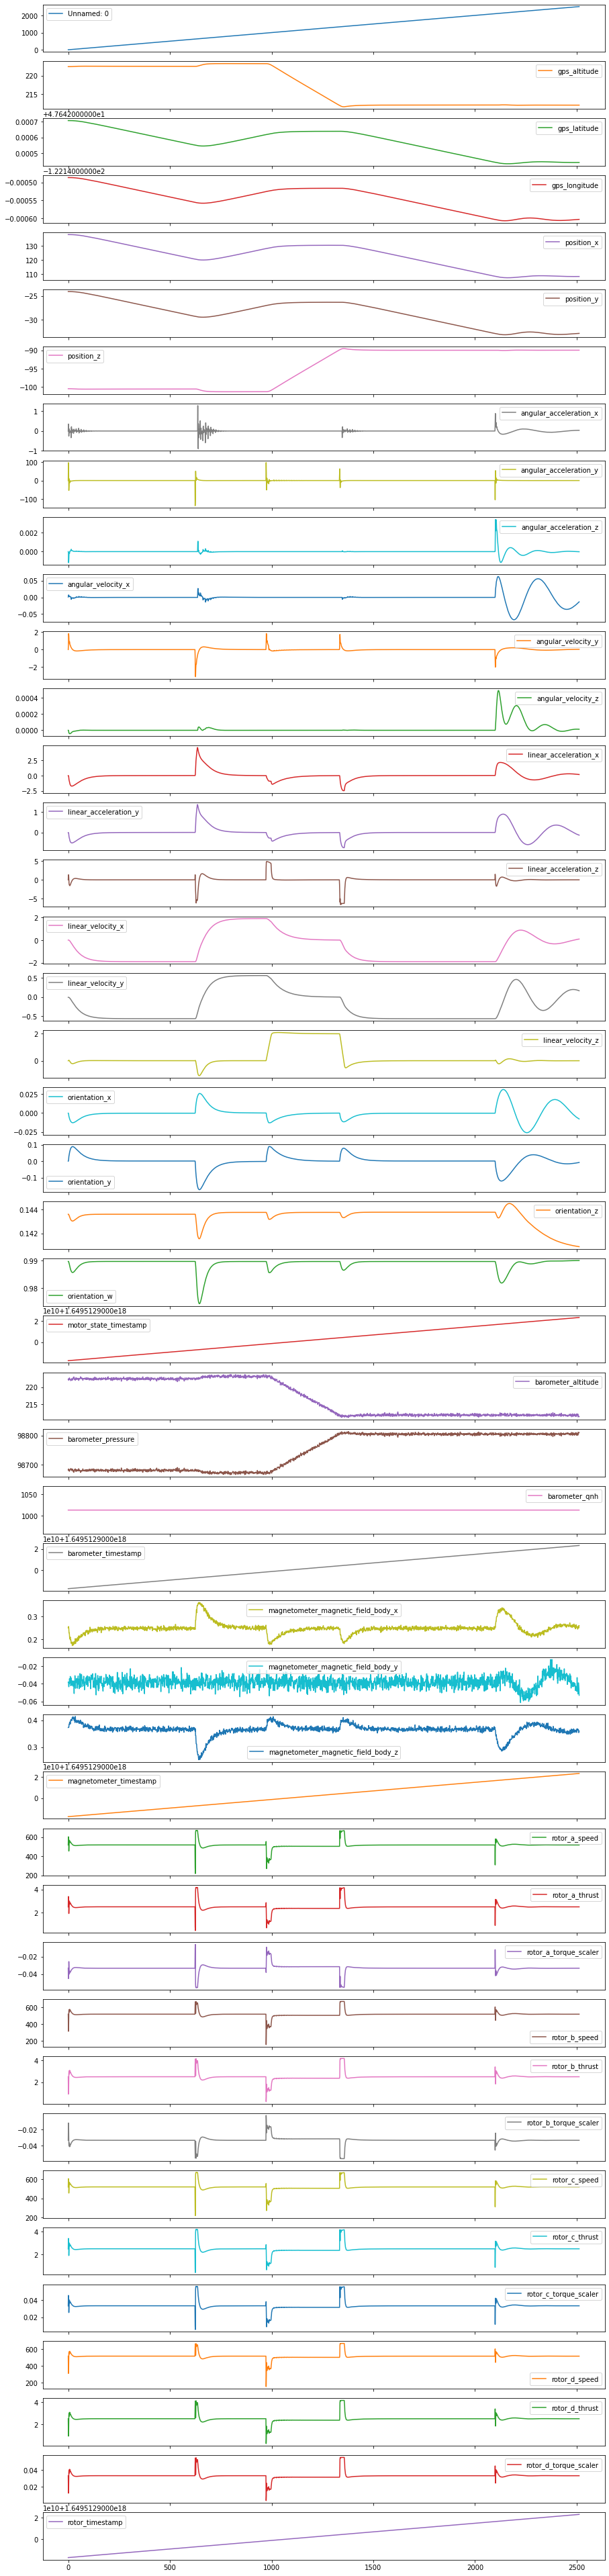

In [44]:
print("All Columns plot")
otuput = df.plot(subplots=True, figsize=(15,70))

###### Hist

All Columns plot


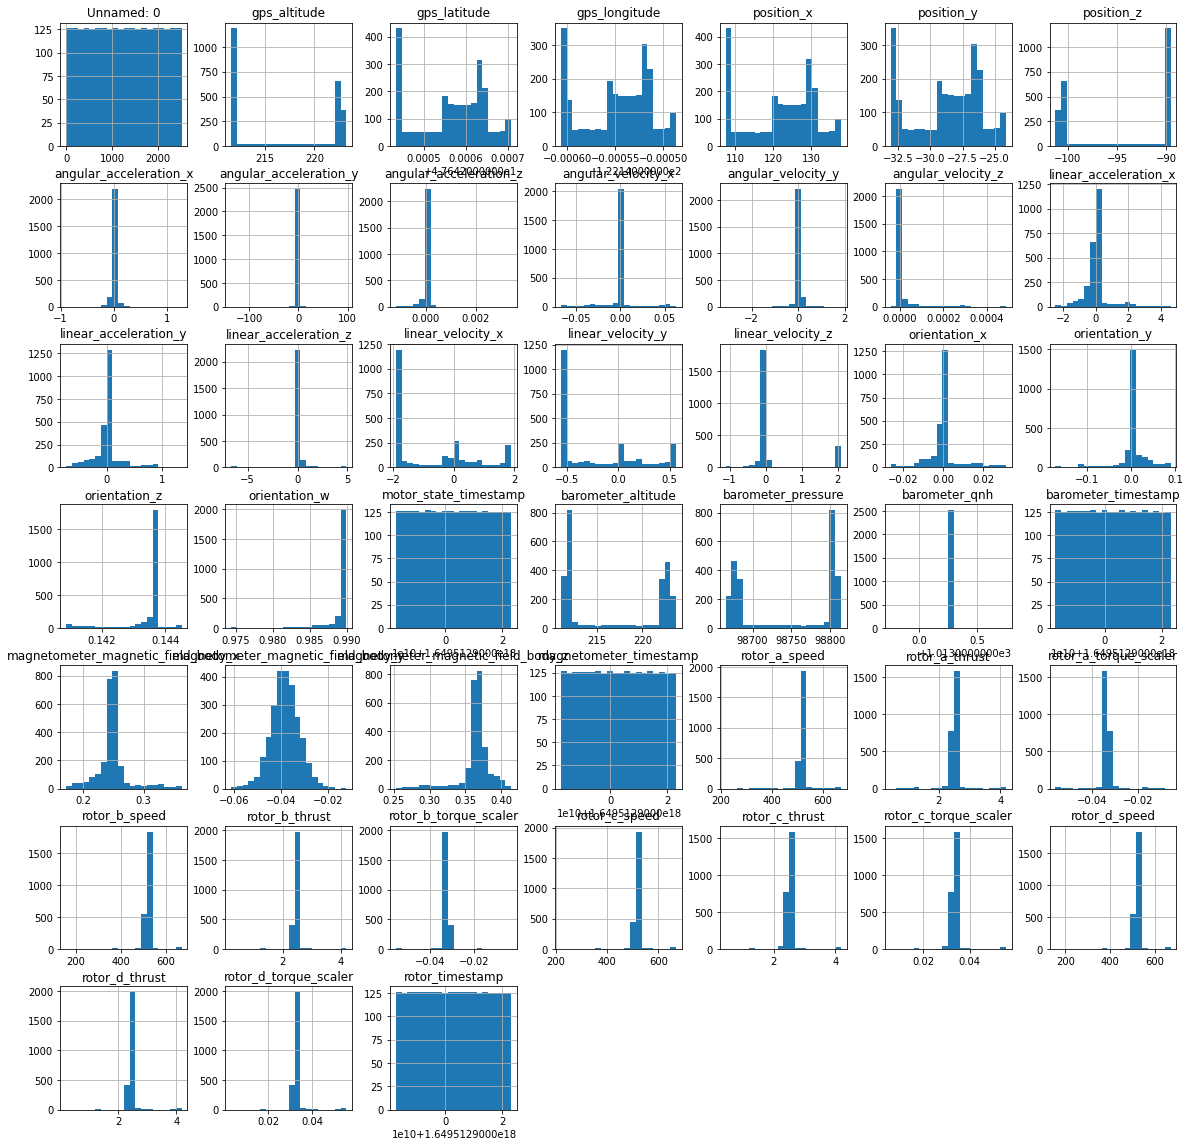

In [70]:
print("All Columns plot")
otuput = df.hist(figsize=(20,20), bins=20)

###### Correlation Matrix

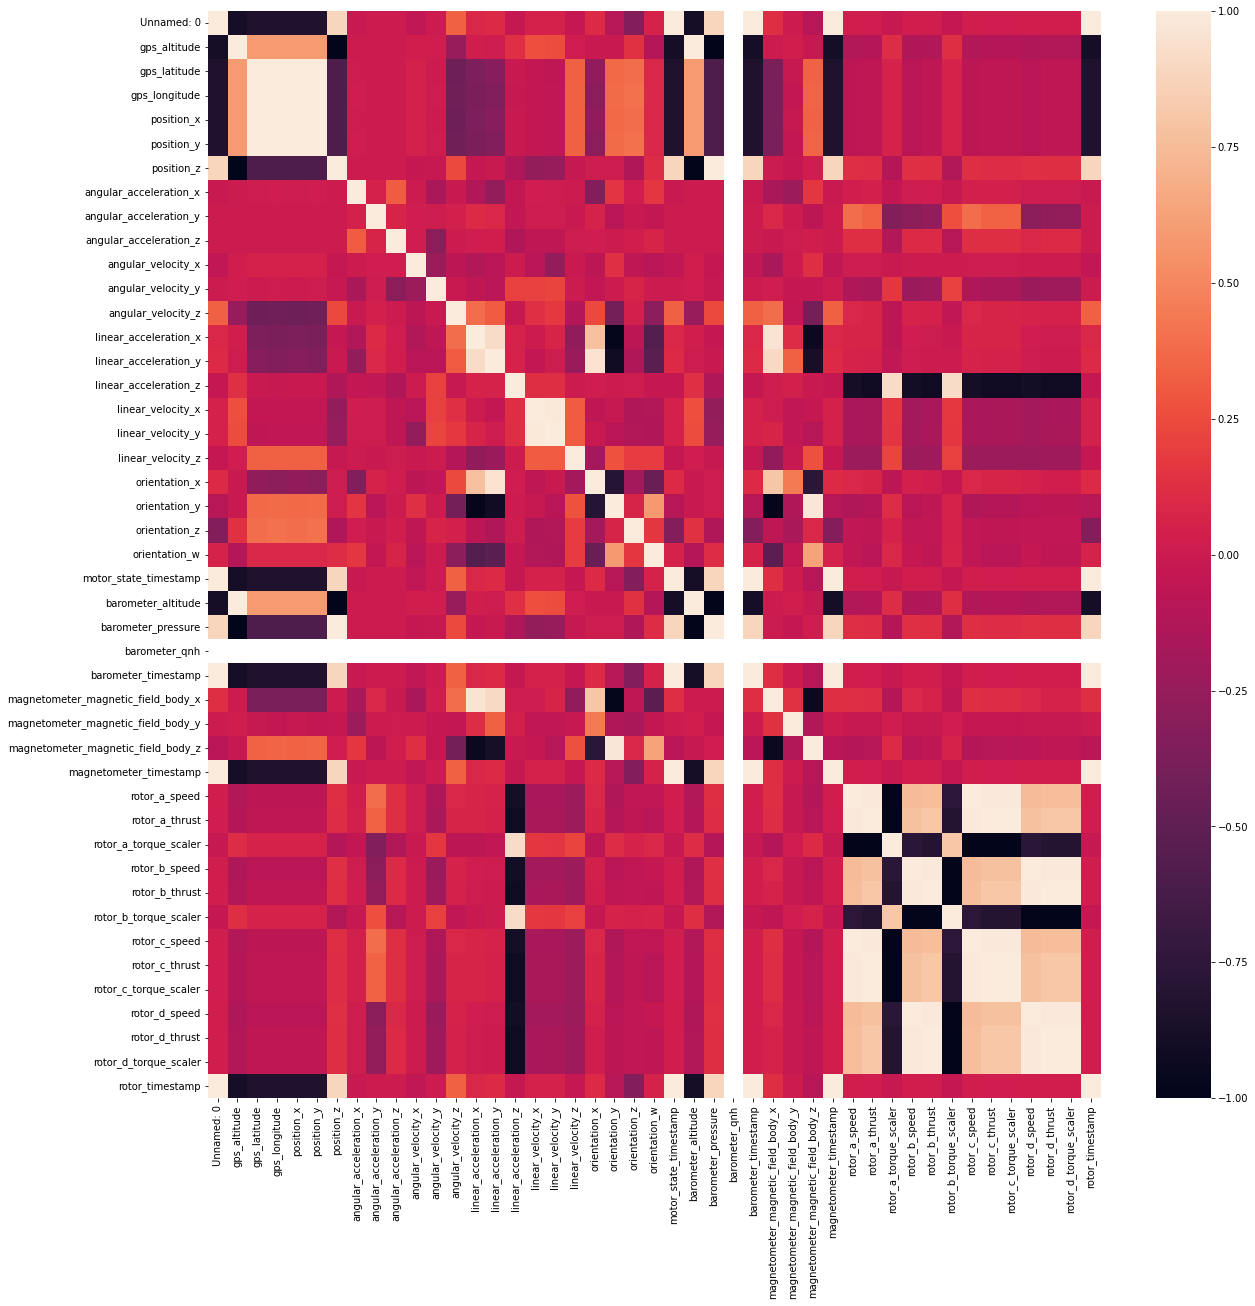

In [64]:
plot_corrolation_heatmap(df, annot=False)

##### Orientation VS Velocity

In [80]:
oricity_df = df[["orientation_x", "orientation_y", "orientation_z", "orientation_w",
                 "linear_velocity_x", "linear_velocity_y", "linear_velocity_z"]]

###### Plot

All Columns plot


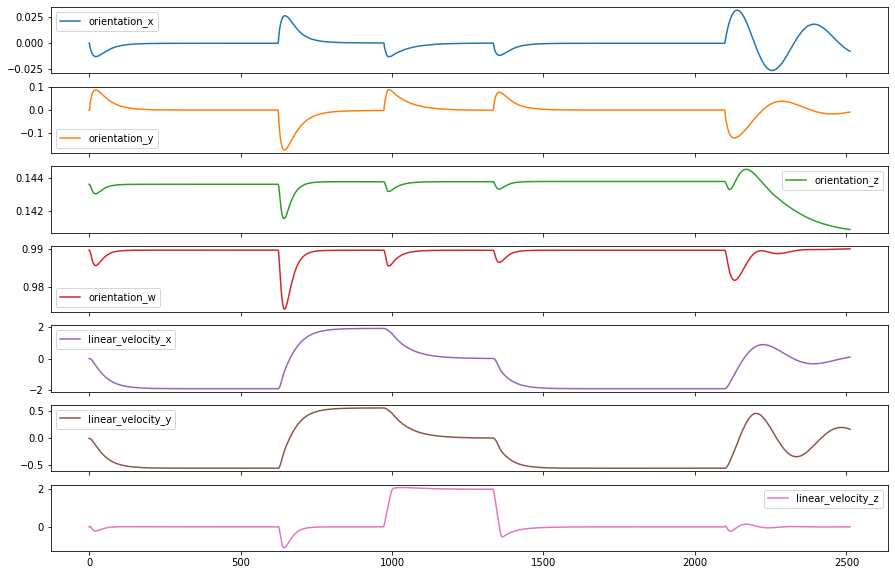

In [84]:
print("All Columns plot")
otuput = oricity_df.plot(subplots=True, figsize=(15,10))

###### Hist

All Columns plot


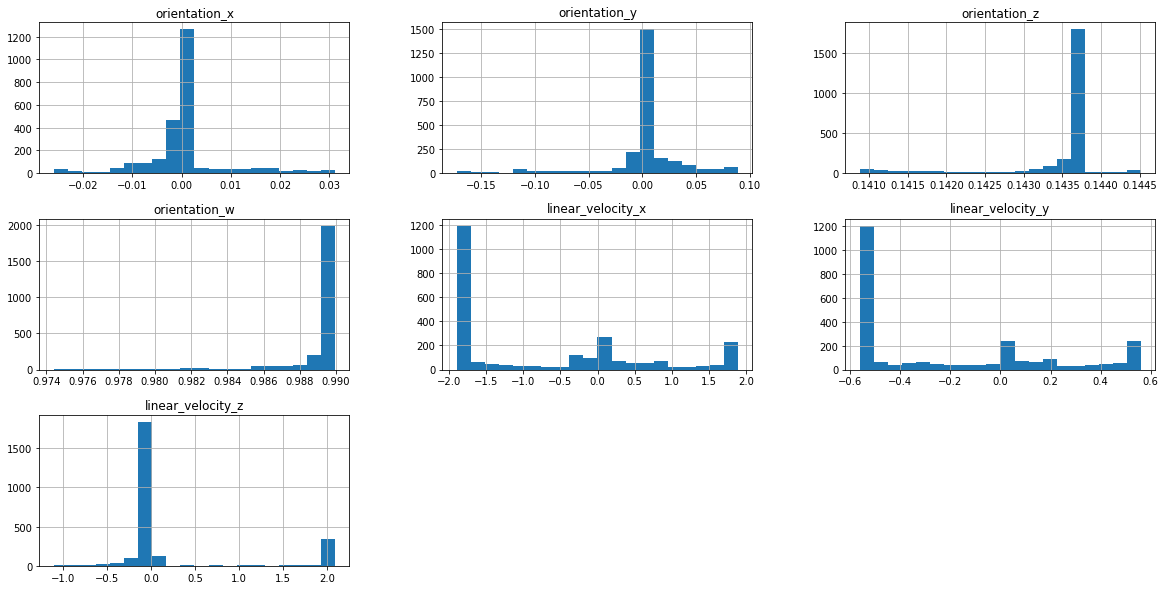

In [83]:
print("All Columns plot")
otuput = oricity_df.hist(figsize=(20,10), bins=20)

###### Correlation Matrix

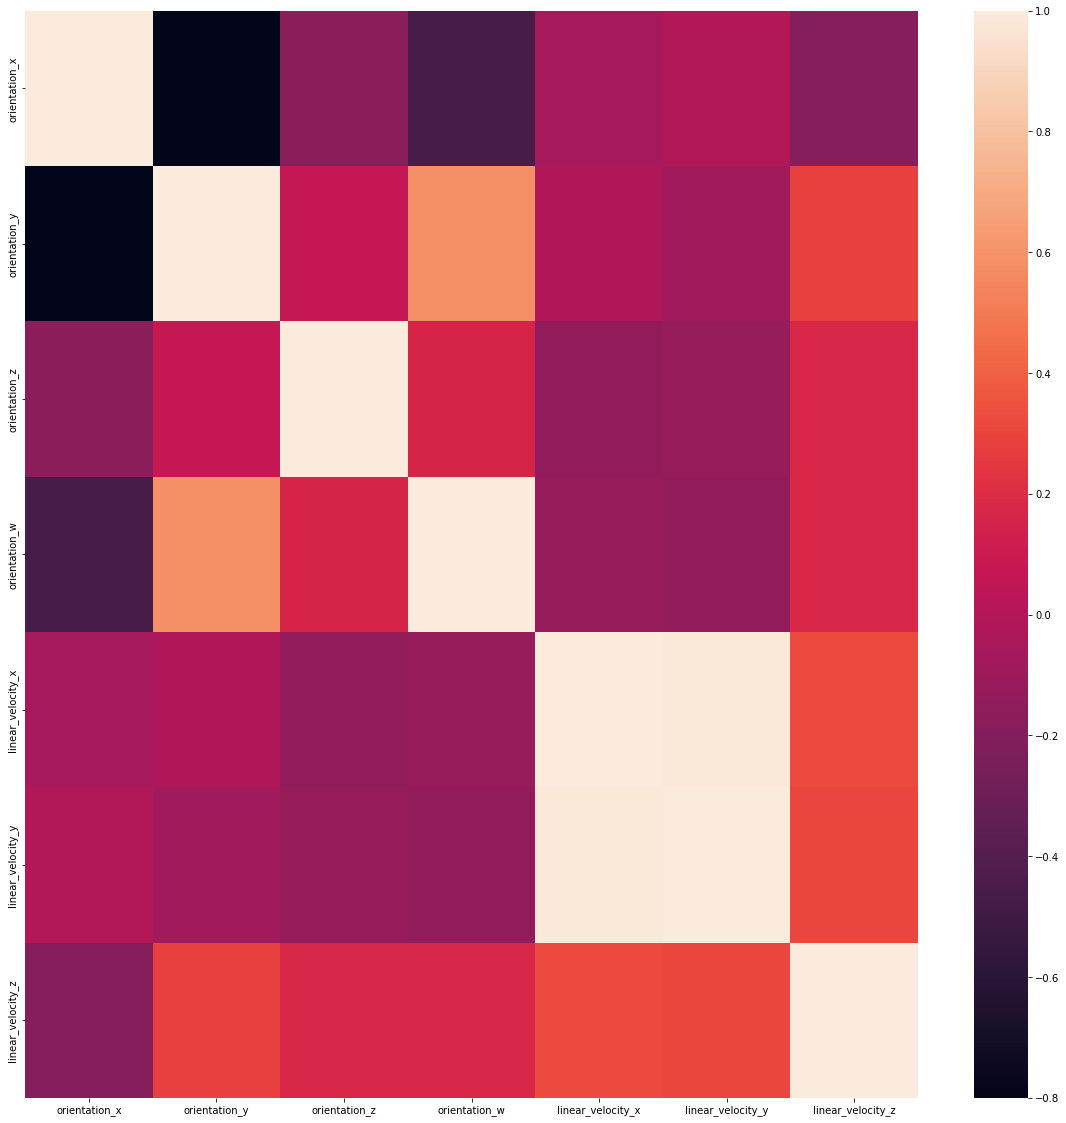

In [85]:
plot_corrolation_heatmap(oricity_df, annot=False)

### Loaded Data

In [19]:
x_df, y_df = load_flight_steps_from_file("bot-simplified-2_09Apr_17:01_record.csv", INPUT_SEQUENCE_COLUMNS, OUTPUT_SEQUENCE_COLUMNS)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

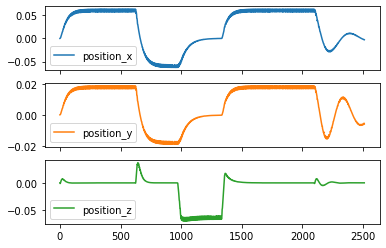

In [24]:
y_df.plot(subplots=True)

### Preprocessed Data